0 background
1 為車流停車 stop 4 congestion
2 停紅綠燈 stop 4 light
3 為行人停車 stop 4 pedestrian
4 為路標停車 stop 4 sign
5 避免撞到路面使用者 Avoid TP
6 穿過十字路口 intersection passing
7 右轉 right turn
8 左轉 left turn
9 左邊分支 left lane branch
10 穿過人行道 crosswalk passing
11 切右道 right lane change
12 切左道 left lane change
13 併道 merge
14 穿過鐵路 railroad passing
15 右邊分支 right lane branch
16 為其他事件停車 Stop for others
17 U轉 U-turn


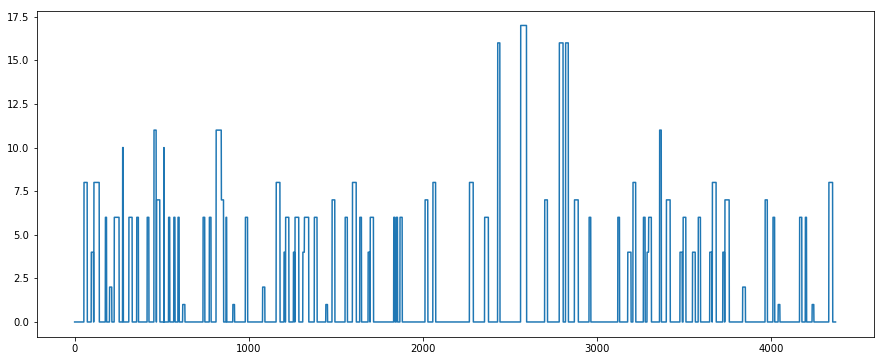

In [105]:
import pickle
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

result_root = '../result/kts350_pred_cross'
annotation_root = '../annotation/'
#session_id = '201704111402'
session_id = '201704151035'

label_dict= pickle.load(open(os.path.join(annotation_root, 'num2label.pkl'), 'r'))
for i in range(len(label_dict.keys())):
    print i, label_dict[i]

gt = pickle.load(open(os.path.join(annotation_root, session_id+'/annotations.pkl'), 'r'))
#temporary operation, join two labels
gt = np.max(gt, axis=1)

plt.figure('Ground truth', figsize=(15, 6))
plt.plot(gt)
plt.show()



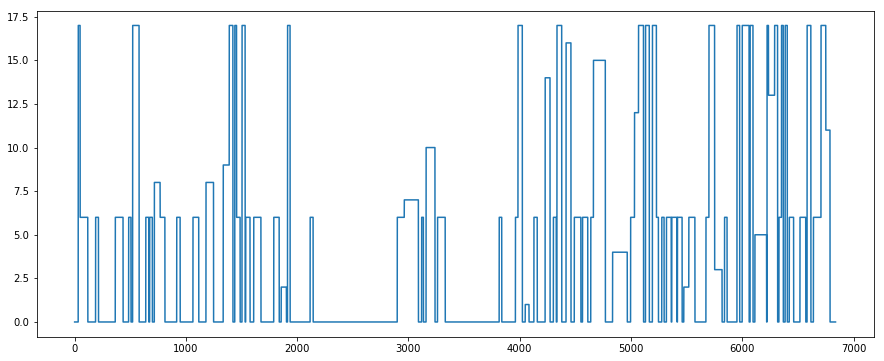

In [40]:
result_name = 'result_hungarian.pkl'

result = pickle.load(open(os.path.join(result_root, result_name), 'r'))
result = result[session_id]

plt.figure('Result', figsize=(15, 6))
plt.plot(result)
plt.show()

In [3]:
def genConMatrix(gt, result):
    """
    Generate the confusion matrix of two segmentations

    Input
        gt   -   ground truth segmentation, vector with size N
        result - cluster result segmentation, vector with size N

    Output
        C    -   the confusion matrix (class by class), size k1 x k2
    """

    s1, G1 = convert_seg(gt)
    s2, G2 = convert_seg(result)

    print "Number of segments of gt: ", len(s1)
    print "Number of segments of result: ", len(s2)

    C = np.zeros((np.max(gt)+1, np.max(result)+1), dtype='int32')
    for i in range(len(s1)-1):
        for j in range(len(s2)-1):
            a = max(s1[i], s2[j])
            b = min(s1[i+1], s2[j+1])

            if a < b:
                C[G1[i], G2[j]] += b - a

    return C


def convert_seg(seg, k=0):
    """
    Convert original segmentation vector

    Input
        seg    -   original segmentation vector with size N

    Output
        s  -  starting position of each segment, list with size m+1, m is the number of segment
        G  -  label of each segment, list with size m 
    """

    if k == 0:
        k = np.max(seg) + 1

    N = seg.shape[0]

    s = [0]
    G = [seg[0]]
    for i in range(1, N):
        if not seg[i] == seg[i-1]:
            s.append(i)
            G.append(seg[i])
    s.append(N)

    return s, G

In [4]:
# compute the confusion matrix
C = genConMatrix(gt, result)
print C

# Evaluation
f1 = []
for i in range(C.shape[0]):
    c = C[i]
    if c[i] == 0:
        f1.append(0)
    else:
        precision = float(c[i]) / np.sum(C[:,i])
        recall = float(c[i]) / np.sum(c)
        f1.append(2*precision*recall / (precision+recall))
    
print "Avg F1-score: %f" % np.mean(np.vstack(f1))
print "F1-score:"
print f1

Number of segments of gt:  318
Number of segments of result:  3030
[[542 164 217 272 190 191 544 336 555 255 140 332  59  35  42 335 216 359]
 [ 18  54  24  44  14   0   0   0   0  34   0   4   0   4  10  18   2  26]
 [  2   0  20  10   6   0   0   0   0   7   0   0   0   0   0  16   0  10]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 17   0  14   0  41  14   9   3  12   4   0  19   0   0   0   9  40   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 83   4   5   7  10  38 155 135  92   8  38  55   0   5   0  17  13  42]
 [ 23   0   0   0   6  19  70  56  28   0  19  20   0   8   0   3  12   5]
 [ 31   1   3   0  12  20  35  14  59   0   7  27   0  13   0  13  16  22]
 [ 13   9   3   5   3   0  11   2   0   9   0   4   0   0   0  13   5  18]
 [  5   0   0   0   0   3   1   5   3   0   7   4   0   0   0   0   0   5]
 [ 15   0   0   0   0   0   6   1  28   0   0   2   0   0   0   5   1  11]
 [  3   0   1   0   0   0   0   0

[]


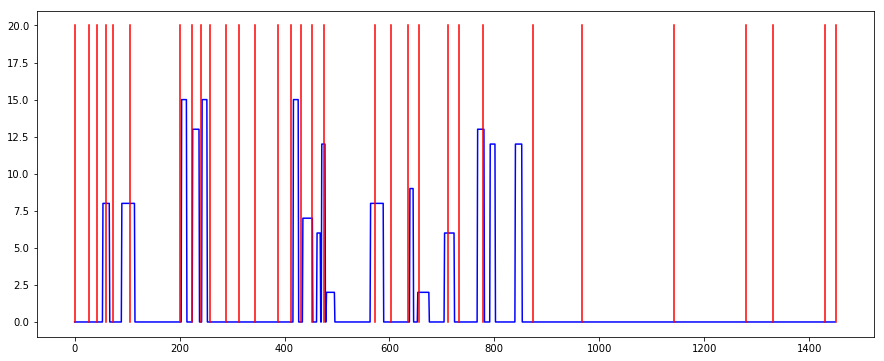

In [106]:
# visualize segmentation
result_root = '../result/kts30_pred_cross1'

session_id = '201704150933'
#session_id = '201704141145'

gt = pickle.load(open(os.path.join(annotation_root, session_id+'/annotations.pkl'), 'r'))
#temporary operation, join two labels
gt = np.max(gt, axis=1)

result_seg_name = 'result_seg.pkl'
result_seg = pickle.load(open(os.path.join(result_root, result_seg_name), 'r'))
s = result_seg[session_id]['s']

tmin = 0
tmax = 10000
s = np.asarray(s)
s2 = s[np.logical_and(s>=tmin, s<=tmax)]
s2 = s2.tolist()
print cp2

plt.figure("Segmentation result", figsize=(15, 6))
plt.plot(gt[tmin:tmax], 'b')
for cp in s2:
    plt.plot([cp,cp], [0,20], 'r')
plt.show()

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float')
        for i in range(cm.shape[0]):
            if cm[i].sum() > 0:
                cm[i] /= cm[i].sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')